In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
merged_df = pd.read_excel('data_interpolated.xlsx')
# Full dictionary for translating column names
column_translation = {
    '지역': 'Region',
    '연도': 'Year',
    '1인당 GRDP 2015-2022': 'GRDP per Capita 2015-2022',
    '근로시간_상용근로일수 (일)': 'Working Days Regular Employees (Days)',
    '근로시간_상용소정실근로시간 (시간)': 'Scheduled Working Hours Regular Employees (Hours)',
    '근로시간_상용월급여액 (원)': 'Monthly Salary Regular Employees (KRW)',
    '근로시간_상용정액급여 (원)': 'Fixed Salary Regular Employees (KRW)',
    '근로시간_상용초과근로시간 (시간)': 'Overtime Hours Regular Employees (Hours)',
    '근로시간_상용초과급여 (원)': 'Overtime Salary Regular Employees (KRW)',
    '근로시간_상용총근로시간 (시간)': 'Total Working Hours Regular Employees (Hours)',
    '근로시간_상용특별급여 (원)': 'Special Bonus Regular Employees (KRW)',
    '지역별 1인가구 비율': 'Single-Person Household Ratio by Region',
    '지역별 건강생활 실천율 2015-2023': 'Health Practice Rate by Region 2015-2023',
    '지역별 경제 참여율 2015-2023': 'Economic Participation Rate by Region 2015-2023',
    '지역별 고용률 2015-2023': 'Employment Rate by Region 2015-2023',
    '지역별 고위험 음주율 2015-2023': 'High-Risk Drinking Rate by Region 2015-2023',
    '지역별 노령화 지수 215-2023': 'Aging Index by Region 2015-2023',
    '지역별 문화기반시설 수 (인구 10만명 당) 2015-2022': 'Number of Cultural Infrastructure per 100K People by Region 2015-2022',
    '지역별 문화생활 인구 비율 2015-2023(2년 단위)': 'Population Ratio Participating in Cultural Activities by Region 2015-2023 (Bi-Annual)',
    '지역별 사교육비': 'Private Education Expenses by Region',
    '지역별 성평등 지수 2017-2022': 'Gender Equality Index by Region 2017-2022',
    '지역별 소득 2015-2022': 'Income by Region 2015-2022',
    '지역별 스트레스 인지율 2015-2023': 'Stress Awareness Rate by Region 2015-2023',
    '지역별 실업률 2015-2023': 'Unemployment Rate by Region 2015-2023',
    '지역별 여성 경제 참여율 2015-2023': 'Economic Participation Rate of Women by Region 2015-2023',
    '지역별 여성 고용률 2015-2023': 'Employment Rate of Women by Region 2015-2023',
    '지역별 여성 실업률 2015-2023': 'Unemployment Rate of Women by Region 2015-2023',
    '지역별 여성 청년층 (19-39) 비율 2015-2023': 'Ratio of Female Youth (19-39) by Region 2015-2023',
    '지역별 여성 초혼 연령 2015-2023': 'Average Age at First Marriage for Women by Region 2015-2023',
    '지역별 월평균 임금 2015-2023': 'Average Monthly Salary by Region 2015-2023',
    '지역별 음주율 2015-2023': 'Drinking Rate by Region 2015-2023',
    '지역별 인구밀도 2015-2023': 'Population Density by Region 2015-2023',
    '지역별 조이혼율 2015-2023': 'Crude Divorce Rate by Region 2015-2023',
    '지역별 조혼인율': 'Crude Marriage Rate by Region',
    '지역별 청년층(19-39) 비율 2015-2023': 'Youth Ratio (19-39) by Region 2015-2023',
    '지역별 평균 연령 2015-2023': 'Average Age by Region 2015-2023'
}


merged_df=merged_df.rename(columns=column_translation)


merged_df_encoded = merged_df
print("열 이름 목록:", merged_df.columns.tolist())
# merged_df_encoded = pd.get_dummies(merged_df, columns=['지역'], drop_first=False)
# region_cols = [col for col in merged_df_encoded.columns if col.startswith('지역_')]
# cities = [col.replace('지역_', '') for col in region_cols]
#print("분석할 도시 목록 (drop_first=False):", cities)

# 1.3. 타겟 변수 분리
if '시군구 합계 출산율 2015-2023' in merged_df_encoded.columns:
    merged_df_encoded = merged_df_encoded.rename(columns={'시군구 합계 출산율 2015-2023': 'Fertility'})
else:
    print("'시군구 합계 출산율 2015-2023' 열이 데이터에 존재하지 않습니다. 타겟 변수를 확인하세요.")

if 'Fertility' in merged_df_encoded.columns:
    X = merged_df_encoded.drop(['Fertility', 'Year'], axis=1)
    y = merged_df_encoded['Fertility']
else:
    print("'출산율' 열이 데이터에 존재하지 않습니다. 타겟 변수를 확인하세요.")


열 이름 목록: ['Region', 'Year', 'GRDP per Capita 2015-2022', 'Working Days Regular Employees (Days)', 'Scheduled Working Hours Regular Employees (Hours)', 'Monthly Salary Regular Employees (KRW)', 'Fixed Salary Regular Employees (KRW)', 'Overtime Hours Regular Employees (Hours)', 'Overtime Salary Regular Employees (KRW)', 'Total Working Hours Regular Employees (Hours)', 'Special Bonus Regular Employees (KRW)', '시군구 합계 출산율 2015-2023', 'Single-Person Household Ratio by Region', 'Health Practice Rate by Region 2015-2023', 'Economic Participation Rate by Region 2015-2023', 'Employment Rate by Region 2015-2023', 'High-Risk Drinking Rate by Region 2015-2023', 'Aging Index by Region 2015-2023', 'Number of Cultural Infrastructure per 100K People by Region 2015-2022', 'Population Ratio Participating in Cultural Activities by Region 2015-2023 (Bi-Annual)', 'Private Education Expenses by Region', 'Gender Equality Index by Region 2017-2022', 'Income by Region 2015-2022', 'Stress Awareness Rate by Regi

In [6]:
df = merged_df_encoded.copy()
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler_y = StandardScaler()

# Reshape y for scaling
y_scaled = scaler_y.fit_transform(df[['Fertility']])



# Update the DataFrame
df['Fertility_Scaled'] = y_scaled

In [7]:

# 타겟 변수와 연도 제거
y = df['Fertility_Scaled']
X = df.drop(['Fertility', 'Fertility_Scaled', 'Year','Region'], axis=1)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 데이터프레임으로 변환
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# VIF 계산 함수
def calculate_vif(X):
    vif = pd.DataFrame()
    vif['Feature'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# VIF 기반 변수 제거
def iterative_vif_removal(X, threshold=30):
    while True:
        vif_df = calculate_vif(X)
        high_vif_features = vif_df[vif_df['VIF'] > threshold]['Feature']
        if high_vif_features.empty:
            break
        # VIF가 가장 높은 변수 제거
        X = X.drop(columns=high_vif_features.iloc[0])
    return X, vif_df

# VIF 감소 실행
X_reduced, final_vif_df = iterative_vif_removal(X_train_df, threshold=10)

print("최종 VIF 감소 후 특성:\n", X_reduced.columns)
print("최종 VIF 값:\n", final_vif_df)

# 테스트 데이터셋에도 동일한 컬럼 적용
X_test_reduced = X_test_df[X_reduced.columns]


최종 VIF 감소 후 특성:
 Index(['Total Working Hours Regular Employees (Hours)',
       'Special Bonus Regular Employees (KRW)',
       'Health Practice Rate by Region 2015-2023',
       'High-Risk Drinking Rate by Region 2015-2023',
       'Population Ratio Participating in Cultural Activities by Region 2015-2023 (Bi-Annual)',
       'Private Education Expenses by Region',
       'Gender Equality Index by Region 2017-2022',
       'Stress Awareness Rate by Region 2015-2023',
       'Employment Rate of Women by Region 2015-2023',
       'Unemployment Rate of Women by Region 2015-2023',
       'Average Age at First Marriage for Women by Region 2015-2023',
       'Average Monthly Salary by Region 2015-2023',
       'Drinking Rate by Region 2015-2023',
       'Population Density by Region 2015-2023',
       'Crude Divorce Rate by Region 2015-2023',
       'Average Age by Region 2015-2023'],
      dtype='object')
최종 VIF 값:
                                               Feature       VIF
0       To

In [8]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

# Lasso 모델 정의
lasso = Lasso(alpha=0.0005)  # alpha 값은 교차 검증을 통해 조정 가능

# 모델 학습
lasso.fit(X_reduced, y_train)

# 변수 선택
model = SelectFromModel(lasso, prefit=True)
X_lasso = model.transform(X_reduced)

# 선택된 변수 이름
selected_features = X_reduced.columns[model.get_support()]
print(len(selected_features))
print("선택된 변수 목록:", selected_features.tolist())

# 테스트 데이터에 동일한 변수 적용
X_test_lasso = X_test_reduced[selected_features]


15
선택된 변수 목록: ['Total Working Hours Regular Employees (Hours)', 'Special Bonus Regular Employees (KRW)', 'Health Practice Rate by Region 2015-2023', 'Population Ratio Participating in Cultural Activities by Region 2015-2023 (Bi-Annual)', 'Private Education Expenses by Region', 'Gender Equality Index by Region 2017-2022', 'Stress Awareness Rate by Region 2015-2023', 'Employment Rate of Women by Region 2015-2023', 'Unemployment Rate of Women by Region 2015-2023', 'Average Age at First Marriage for Women by Region 2015-2023', 'Average Monthly Salary by Region 2015-2023', 'Drinking Rate by Region 2015-2023', 'Population Density by Region 2015-2023', 'Crude Divorce Rate by Region 2015-2023', 'Average Age by Region 2015-2023']


c:\Users\yooji\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [9]:
X_train = X_lasso
X_test = X_test_lasso

In [10]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# 2. 트리 기반 모델 적용 (XGBoost)
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,          # 트리 수를 줄여 과적합 방지
    learning_rate=0.003,        # 낮은 학습률로 안정적인 학습
    max_depth=9,               # 낮은 트리 깊이로 모델 단순화
    subsample=0.7,             # 데이터 샘플링 비율 감소
    colsample_bytree=0.7,      # 특성 샘플링 비율 감소
    gamma=1,                   # 분할 최소 손실 감소
    min_child_weight=2,        # 자식 노드의 최소 가중치

    random_state=42,
    verbosity=0
)
# 모델 학습
xgb_model.fit(
    X_reduced, y_train,
    eval_set=[(X_test_reduced, y_test)],
    verbose=False
)




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.003, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=2, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
 #예측 및 평가
y_pred_xgb = xgb_model.predict(X_test_reduced)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost MSE: {mse_xgb:.2f}, R²: {r2_xgb:.2f}')



XGBoost MSE: 0.08, R²: 0.92


In [12]:
import lightgbm as lgb

# LightGBM 모델 정의
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    n_estimators=100,          # Reduced number of trees
    learning_rate=0.05,        # Lower learning rate
    max_depth=3,               # Shallower trees
    min_child_samples=5,       # Minimum samples per leaf
    num_leaves=31,             # Controls tree complexity
    subsample=0.7,             # Subsample ratio for training instances
    colsample_bytree=0.7,      # Subsample ratio for features
    gamma=1,                   # Minimum loss reduction to make a split
    min_child_weight=2,        # Minimum sum of instance weight needed in a child
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1,              # L2 regularization
    random_state=42,
    verbosity=-1
)

# Initialize Leave-One-Out Cross-Validation

lgb_model.fit(
    X_reduced, y_train,
    eval_set=[(X_test_reduced, y_test)],
)

Exception in thread Thread-10 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\yooji\anaconda3\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "c:\Users\yooji\anaconda3\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\yooji\anaconda3\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xc0 in position 24: invalid start byte
c:\Users\yooji\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
'NoneType' object has no attribute 'splitlines'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\yooji\anaconda3\Lib\site-pac

LGBMRegressor(colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=3,
              min_child_samples=5, min_child_weight=2, objective='regression',
              random_state=42, reg_alpha=0.1, reg_lambda=1, subsample=0.7,
              verbosity=-1)

In [13]:
from sklearn.model_selection import LeaveOneOut, cross_val_score

# 예측 및 평가
y_pred_lgb = lgb_model.predict(X_test_reduced)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)
print(f'LightGBM MSE: {mse_lgb:.2f}, R²: {r2_lgb:.2f}')



LightGBM MSE: 0.04, R²: 0.96


In [14]:
selected_features

Index(['Total Working Hours Regular Employees (Hours)',
       'Special Bonus Regular Employees (KRW)',
       'Health Practice Rate by Region 2015-2023',
       'Population Ratio Participating in Cultural Activities by Region 2015-2023 (Bi-Annual)',
       'Private Education Expenses by Region',
       'Gender Equality Index by Region 2017-2022',
       'Stress Awareness Rate by Region 2015-2023',
       'Employment Rate of Women by Region 2015-2023',
       'Unemployment Rate of Women by Region 2015-2023',
       'Average Age at First Marriage for Women by Region 2015-2023',
       'Average Monthly Salary by Region 2015-2023',
       'Drinking Rate by Region 2015-2023',
       'Population Density by Region 2015-2023',
       'Crude Divorce Rate by Region 2015-2023',
       'Average Age by Region 2015-2023'],
      dtype='object')

In [15]:
# 나눔 고딕 폰트 설치
!sudo apt-get install -y fonts-nanum

# Matplotlib에 나눔 고딕 폰트 적용
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔 고딕 폰트 경로
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

# 한글 폰트 설정 확인
fm.findfont(fm.FontProperties(family='NanumGothic'))


'sudo' is not recognized as an internal or external command,findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.

operable program or batch file.


'C:\\Users\\yooji\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'

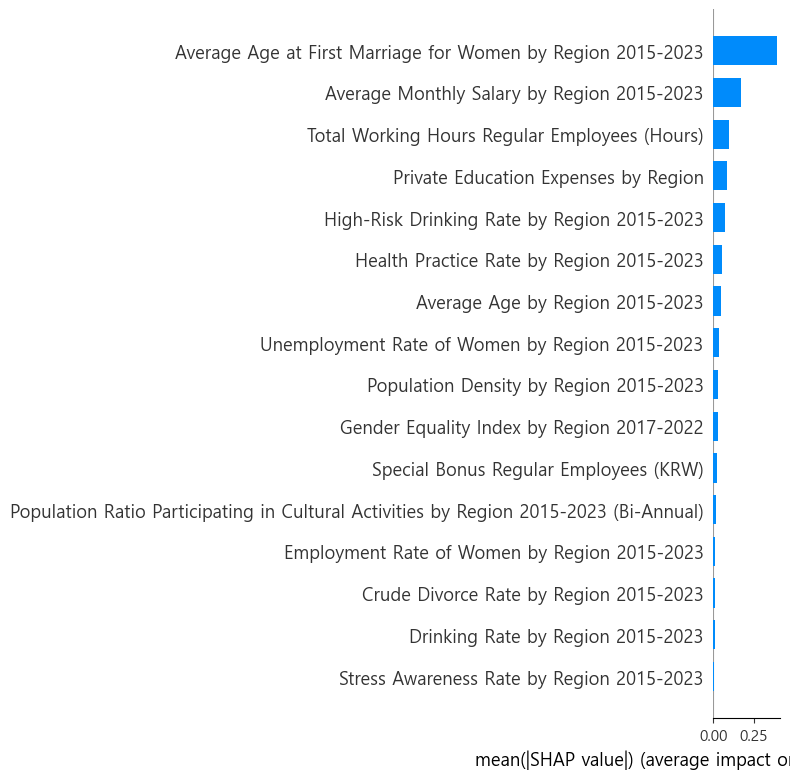

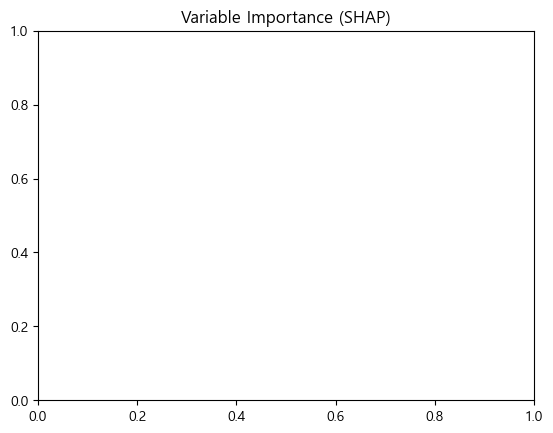

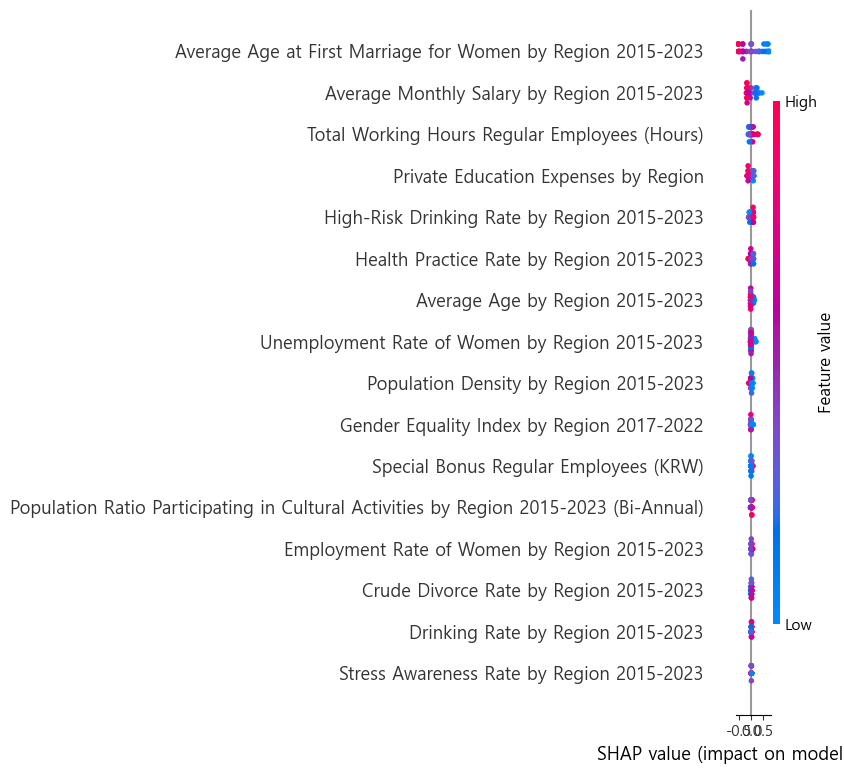

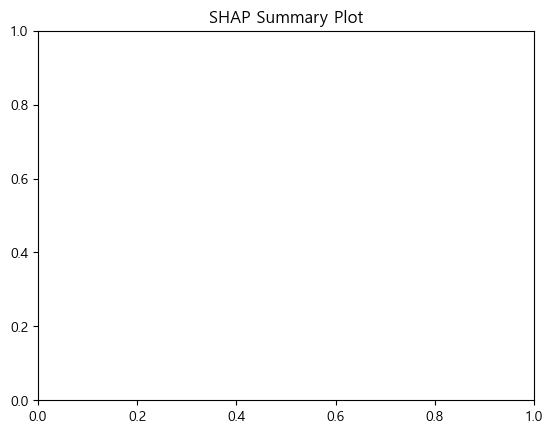

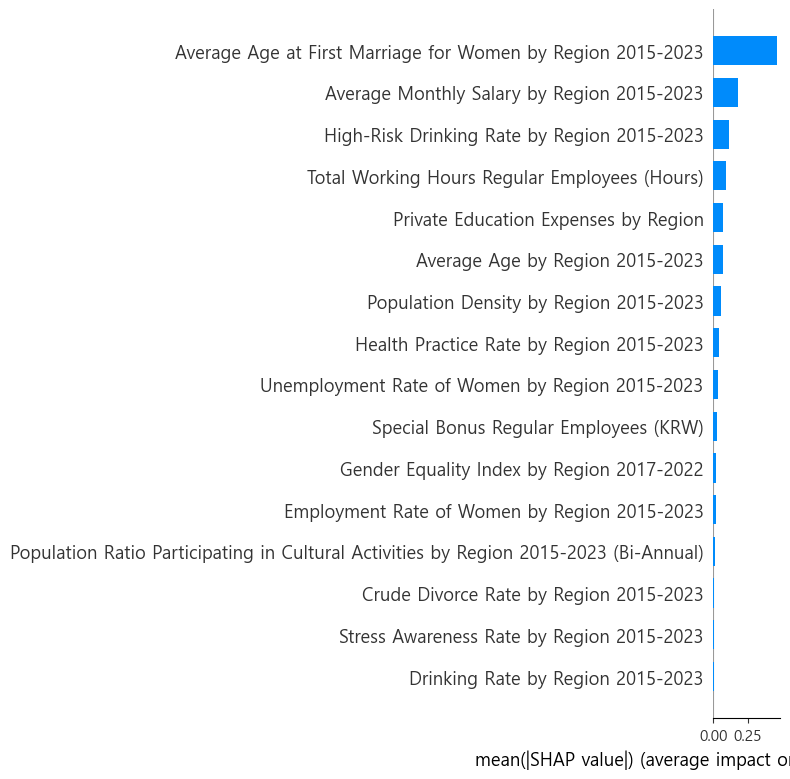

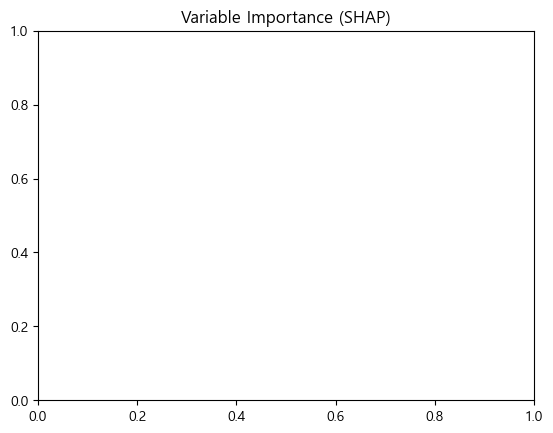

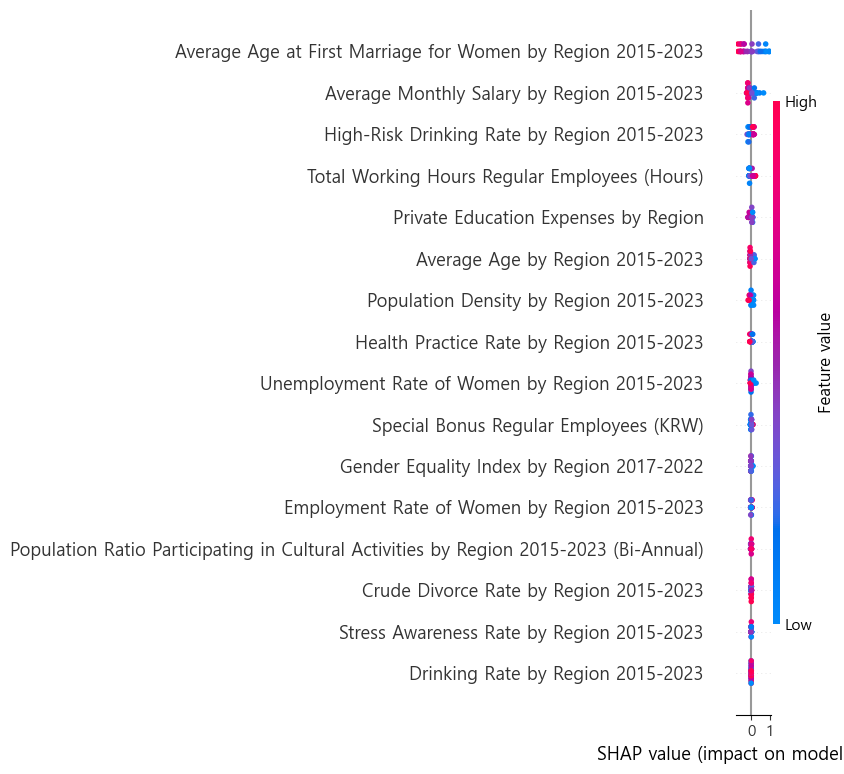

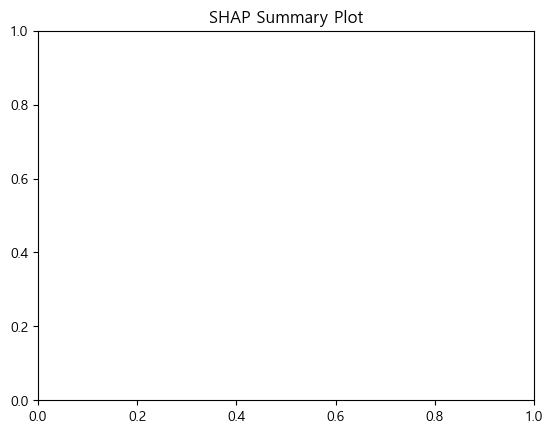

In [18]:

# 3. SHAP 분석
for model in [xgb_model,lgb_model]:
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test_reduced)
    from matplotlib import rc

    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우 "맑은 고딕"
    # plt.rcParams['font.family'] = 'AppleGothic' # macOS의 경우
    # plt.rcParams['font.family'] = 'NanumGothic' # Ubuntu의 경우

    # 음수 기호 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False
    # 변수 중요도 시각화 (막대 그래프)
    shap.summary_plot(shap_values,X_test_reduced, plot_type="bar")
    plt.title("Variable Importance (SHAP)")
    plt.show()

    # 변수 중요도 시각화 (점 플롯)
    shap.summary_plot(shap_values, X_test_reduced)
    plt.title("SHAP Summary Plot")
    plt.show()
